In [1]:
import pandas as pd
import numpy as np
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import seaborn as sb
import matplotlib.pyplot as plt

### Cargar datos

In [2]:
# Cargar los datos
cleaned_data_path = '../../datasets/cleaned_data.csv'
data_all = pd.read_csv(cleaned_data_path)

C:\Users\Ketbome\AppData\Local\Temp\ipykernel_19308\2666340801.py:3: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  data_all = pd.read_csv(cleaned_data_path)


### Analisis datos

In [3]:
# solo dejar los que en COD_ENSE 110, 310, 360, 410, 510, 610, 710, 910
data_clear = data_all[data_all['COD_ENSE'].isin([110, 310, 360, 410, 510, 610, 710, 910])]

In [4]:
# Asegúrate de que 'COD_ENSE' y 'COD GRADO' sean interpretados como listas en la condición
def asignar_curso(row):
    if row['COD_ENSE'] == 110:
        return row['COD_GRADO']
    elif row['COD_ENSE'] in [310,360, 410, 510, 610, 710, 810, 910]:
        return row['COD_GRADO'] + 8
    else:
        return None

# Aplica la función a cada fila (axis=1) y crea la nueva columna 'Curso'
data_new = data_clear.apply(asignar_curso, axis=1)

In [5]:
# solo dejar los que en COD_TIP_CUR 0 de la data_all
data_clear = data_clear[data_clear['COD_TIP_CUR'].isin([0])]

# solo dejar los COD_JOR 1, 2 y 3
data_clear = data_clear[data_clear['COD_JOR'].isin([1, 3])]

# Solo dejar genero masculino y femenino
data_clear = data_clear[data_clear['GEN_ALU'].isin([1, 2])]

# Solo dejar COD_DEPE2 1 2 3
data_clear = data_clear[data_clear['COD_DEPE2'].isin([1, 2, 3])]

# Solo dejar COD_ENSE2 2, 5 y 7
data_clear = data_clear[data_clear['COD_ENSE2'].isin([2, 5, 7])]

# Solo dejar COD_SEC 0
data_clear = data_clear[data_clear['COD_SEC'].isin([0])]


In [6]:
# Cuenta las ocurrencias de cada valor en 'COD_COM_RBD'
counts = data_clear['COD_COM_RBD'].value_counts()

# Crea una máscara donde cada valor es True si el conteo correspondiente es mayor a 1000
mask = data_clear['COD_COM_RBD'].isin(counts[counts > 1000].index)

# Aplica la máscara para filtrar el DataFrame
data_clear = data_clear[mask]

In [7]:
# agregar la columna 'Curso' a data_all
data_clear['CURSO'] = data_new

In [8]:
# Convertir la columna a números, los valores inválidos se convierten en NaN
data_clear['EDAD_ALU'] = pd.to_numeric(data_clear['EDAD_ALU'], errors='coerce')

# Eliminar las filas con NaN en la columna 'EDAD_ALU'
data_clear = data_clear.dropna(subset=['EDAD_ALU'])

# Edad de alumno numero entero
data_clear['EDAD_ALU'] = data_clear['EDAD_ALU'].astype(int)

In [9]:
data_clear['COD_ENSE'].value_counts()

COD_ENSE
110    1747584
310     639072
510      24347
410      17696
610      11797
710       6655
910        136
Name: count, dtype: int64

<Axes: >

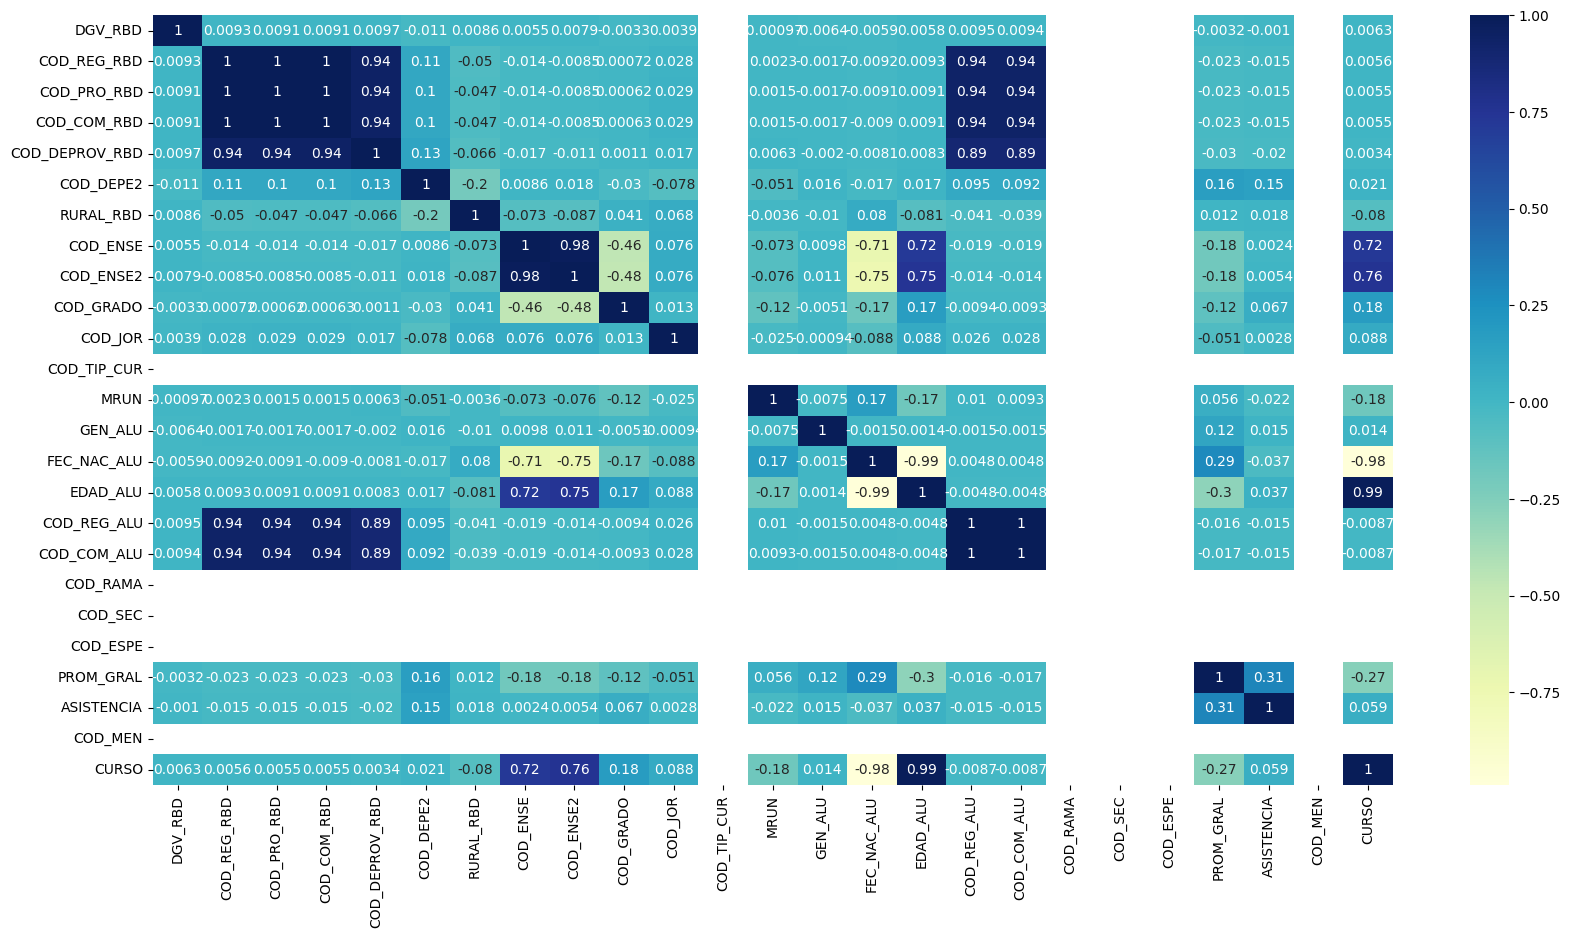

In [10]:
#Observar correlacion para hacer mas limpieza
plt.figure(figsize=(20,10))
sb.heatmap((data_clear.drop(['ï»¿AGNO', 'COD_DES_CUR', 'ESTADO_ESTAB','COD_DEPE', 'RBD', 'NOM_RBD', 'NOM_REG_RBD_A', 'NOM_COM_RBD', 'NOM_DEPROV_RBD', 'LET_CUR', 'NOM_COM_ALU', 'SIT_FIN', 'SIT_FIN_R'], axis = 1)).corr(), annot=True, cmap='YlGnBu')

In [11]:
data_clear.head()

,ï»¿AGNO,RBD,DGV_RBD,NOM_RBD,COD_REG_RBD,NOM_REG_RBD_A,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,COD_DEPROV_RBD,...,NOM_COM_ALU,COD_RAMA,COD_SEC,COD_ESPE,PROM_GRAL,ASISTENCIA,SIT_FIN,SIT_FIN_R,COD_MEN,CURSO
14453,2022,45,0,COLEGIO ITALIANO SANTA ANA,15,AYP,151,15101,ARICA,151,...,SAN RAMÃN,0,0,0,6.8,95,P,P,0,1
14454,2022,45,0,COLEGIO ITALIANO SANTA ANA,15,AYP,151,15101,ARICA,151,...,SANTIAGO,0,0,0,6.7,85,P,P,0,1
14455,2022,45,0,COLEGIO ITALIANO SANTA ANA,15,AYP,151,15101,ARICA,151,...,ARICA,0,0,0,6.7,98,P,P,0,1
14456,2022,45,0,COLEGIO ITALIANO SANTA ANA,15,AYP,151,15101,ARICA,151,...,SANTIAGO,0,0,0,6.5,88,P,P,0,1
14457,2022,45,0,COLEGIO ITALIANO SANTA ANA,15,AYP,151,15101,ARICA,151,...,SANTIAGO,0,0,0,6.4,96,P,P,0,1


In [12]:
# Eliminar columnas
data = data_clear.drop(['ï»¿AGNO', 'COD_DES_CUR', 'ESTADO_ESTAB','COD_DEPE', 'RBD', 'NOM_RBD', 'NOM_REG_RBD_A', 'NOM_COM_RBD', 'NOM_DEPROV_RBD', 'LET_CUR', 'NOM_COM_ALU', 'SIT_FIN', 'SIT_FIN_R', 'COD_GRADO', 'DGV_RBD', 'COD_PRO_RBD', 'COD_TIP_CUR', 'MRUN', 'FEC_NAC_ALU', 'COD_RAMA', 'COD_SEC', 'COD_ESPE', 'COD_MEN'], axis=1)
data = data.drop(['COD_DEPROV_RBD', 'COD_JOR', 'COD_REG_RBD', 'RURAL_RBD', 'COD_REG_ALU', 'COD_COM_ALU', 'COD_ENSE'], axis=1)# 'COD_DEPROV_RBD', 'COD_DES_CUR', 'COD_JOR', 'COD_REG_RBD', 'COD_COM_RBD', 'RURAL_RBD', 'COD_REG_ALU', 'COD_COM_ALU', 'COD_ENSE'

In [13]:
data.head()

,COD_COM_RBD,COD_DEPE2,COD_ENSE2,GEN_ALU,EDAD_ALU,PROM_GRAL,ASISTENCIA,CURSO
14453,15101,2,2,2,7,6.8,95,1
14454,15101,2,2,2,7,6.7,85,1
14455,15101,2,2,2,7,6.7,98,1
14456,15101,2,2,2,7,6.5,88,1
14457,15101,2,2,2,7,6.4,96,1


### Correlacion

<Axes: >

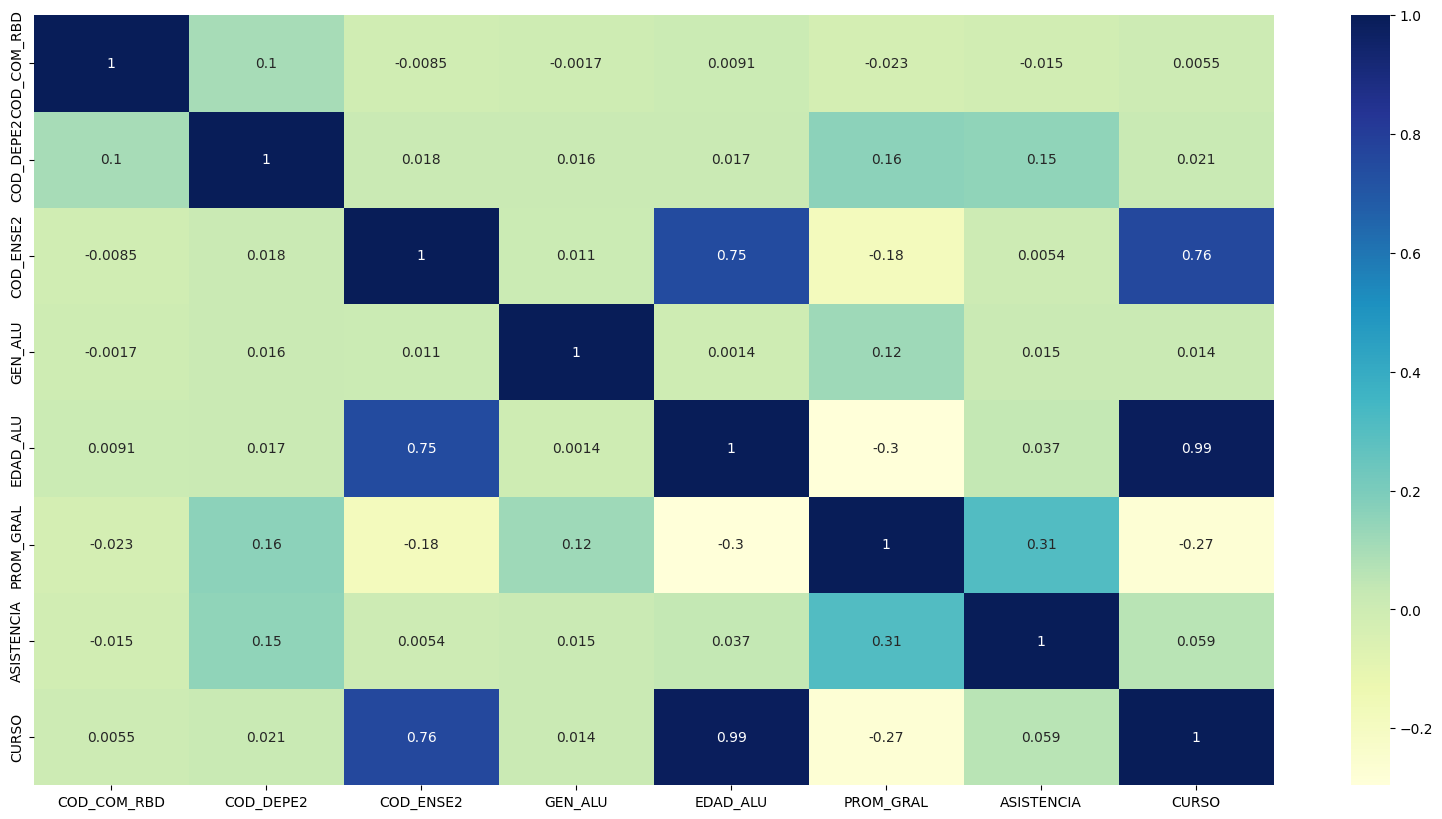

In [14]:
#Observar correlacion para hacer mas limpieza
plt.figure(figsize=(20,10))
sb.heatmap(data.corr(), annot=True, cmap='YlGnBu')

### Division de datos

In [15]:
# División de datos
X = data.drop(columns=['PROM_GRAL'])
y = data['PROM_GRAL']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

### Escalado / Normalizacion

In [16]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras import layers

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Ajustar y transformar
X_test_scaled = scaler.transform(X_test) # Solo transformar

In [17]:
# Guardar scaler para usarlo en la aplicación web
from joblib import dump
dump(scaler, 'scaler.joblib')

['scaler.joblib']

### Early stopping

In [17]:
# Stop training when a monitored metric has stopped improving.
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', # Monitorea la perdida de validación
    patience=5, # Cantidad de épocas que se esperará sin mejora
    restore_best_weights=True, # Restaura los mejores pesos
)

### Hyperband

In [432]:
def model_builder(hp):
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=64)
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=128)
    hp_layers = hp.Int('layers', min_value=1, max_value=2, step=1)

    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train_scaled.shape[1],)))

    for i in range(hp_layers):
        if i == 0:
            model.add(keras.layers.Dense(units=hp_units1, activation='relu'))
        elif i == 1:
            model.add(keras.layers.Dense(units=hp_units2, activation='relu'))

    model.add(keras.layers.Dense(1))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mae',
        metrics=['mse']
    )

    return model

In [433]:
hyperband_tuner = kt.Hyperband(
    model_builder,
    objective='val_loss',
    max_epochs=20,
    factor=10, # Numero de iteraciones por modelo
    directory='/tmp/hyperband',
    project_name='tuning_rnn',
    overwrite=True
)

hyperband_tuner.search_space_summary()

Search space summary
Default search space size: 4
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [434]:
hyperband_tuner.search(
    X_train_scaled,
    y_train,
    epochs=20,
    batch_size=1028,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

hyperband_tuner.results_summary()

Trial 20 Complete [00h 01m 49s]
val_loss: 0.38997840881347656

Best val_loss So Far: 0.3893953561782837
Total elapsed time: 00h 12m 22s
Results summary
Results in /tmp/hyperband\tuning_rnn
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0017 summary
Hyperparameters:
units1: 480
units2: 288
layers: 1
learning_rate: 0.01
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.3893953561782837

Trial 0018 summary
Hyperparameters:
units1: 352
units2: 288
layers: 2
learning_rate: 0.01
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.3899581730365753

Trial 0019 summary
Hyperparameters:
units1: 480
units2: 32
layers: 2
learning_rate: 0.01
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.38997840881347656

Trial 0014 summary
Hyperparameters:
units1: 32
units2: 288
layers: 2
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.391416

In [435]:
best_hyperband_model = hyperband_tuner.get_best_hyperparameters(num_trials=1)[0]

best_hyperband_model.get('units1'), best_hyperband_model.get('units2'), best_hyperband_model.get('layers'), best_hyperband_model.get('learning_rate')

(480, 288, 1, 0.01)

In [443]:
# predecir con el mejor modelo de hyperband
model = hyperband_tuner.hypermodel.build(best_hyperband_model)

model.fit(
    X_train_scaled,
    y_train,
    epochs=20,
    batch_size=1028,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
1524/1524 [==============================] - 8s 4ms/step - loss: 0.4256 - mse: 0.3671 - val_loss: 0.4053 - val_mse: 0.2785
Epoch 2/20
1524/1524 [==============================] - 6s 4ms/step - loss: 0.3982 - mse: 0.2675 - val_loss: 0.4060 - val_mse: 0.2902
Epoch 3/20
1524/1524 [==============================] - 7s 5ms/step - loss: 0.3968 - mse: 0.2657 - val_loss: 0.3917 - val_mse: 0.2593
Epoch 4/20
1524/1524 [==============================] - 6s 4ms/step - loss: 0.3960 - mse: 0.2646 - val_loss: 0.3952 - val_mse: 0.2605
Epoch 5/20
1524/1524 [==============================] - 6s 4ms/step - loss: 0.3951 - mse: 0.2636 - val_loss: 0.3914 - val_mse: 0.2557
Epoch 6/20
1524/1524 [==============================] - 7s 5ms/step - loss: 0.3945 - mse: 0.2630 - val_loss: 0.3932 - val_mse: 0.2561
Epoch 7/20
1524/1524 [==============================] - 8s 5ms/step - loss: 0.3938 - mse: 0.2622 - val_loss: 0.3935 - val_mse: 0.2616
Epoch 8/20
1524/1524 [==============================] - 8s 5ms

In [444]:
# Evaluar el modelo
y_pred = model.predict(X_test_scaled)

15296/15296 [==============================] - 20s 1ms/step


In [445]:
# aproximar el valor a 1 digito decimal de y_pred
y_pred = np.round(y_pred, decimals=1)
y_pred

array([[5.9],
       [5.9],
       [6.2],
       ...,
       [6.3],
       [6.5],
       [6.5]], dtype=float32)

In [446]:
# Métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MAE: ', mae)
print('MSE: ', mse)
print('R2: ', r2)

MAE:  0.39263819205305944
MSE:  0.25627488010198163
R2:  0.29108099019660005


### Red neuronal

In [21]:
# Construcción del modelo de red neuronal
modelo = keras.Sequential([
    layers.InputLayer(input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(288, activation='leaky_relu'),
    layers.Dense(1)
])

In [22]:
from tensorflow.keras.optimizers import Adam

# Compilación del modelo
modelo.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='mae',
    metrics=['mse']
)

In [23]:
# Entrenamiento
modelo.fit(
    X_train_scaled, 
    y_train, 
    epochs=15,
    batch_size=1028, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/15
1524/1524 [==============================] - 6s 3ms/step - loss: 0.4331 - mse: 0.4089 - val_loss: 0.4005 - val_mse: 0.2699
Epoch 2/15
1524/1524 [==============================] - 4s 3ms/step - loss: 0.3971 - mse: 0.2662 - val_loss: 0.4005 - val_mse: 0.2588
Epoch 3/15
1524/1524 [==============================] - 4s 3ms/step - loss: 0.3967 - mse: 0.2657 - val_loss: 0.3929 - val_mse: 0.2600
Epoch 4/15
1524/1524 [==============================] - 4s 3ms/step - loss: 0.3955 - mse: 0.2642 - val_loss: 0.3939 - val_mse: 0.2633
Epoch 5/15
1524/1524 [==============================] - 4s 3ms/step - loss: 0.3953 - mse: 0.2639 - val_loss: 0.3929 - val_mse: 0.2647
Epoch 6/15
1524/1524 [==============================] - 4s 3ms/step - loss: 0.3943 - mse: 0.2627 - val_loss: 0.3928 - val_mse: 0.2557
Epoch 7/15
1524/1524 [==============================] - 4s 3ms/step - loss: 0.3942 - mse: 0.2624 - val_loss: 0.3924 - val_mse: 0.2582
Epoch 8/15
1524/1524 [==============================] - 4s 3ms

In [13]:
# Cargar modelo
modelo = keras.models.load_model('Final_Model.h5')

In [16]:
# predicciones
y_pred = modelo.predict(X_test_scaled)

15296/15296 [==============================] - 19s 1ms/step


In [17]:
# aproximar el valor a 1 digito decimal de y_pred
y_pred = np.round(y_pred, decimals=1)
y_pred

array([[5.9],
       [5.9],
       [6.2],
       ...,
       [6.3],
       [6.4],
       [6.5]], dtype=float32)

In [18]:
# Métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MAE: ', mae)
print('MSE: ', mse)
print('R2: ', r2)

MAE:  0.3903456571492518
MSE:  0.2592676391388344
R2:  0.2828022865946648


In [31]:
# Guardar datos en un txt, columnas usadas y mae, mse, r2
with open('Final/Resultados Ultimo.txt', 'w') as f:
    f.write('Columnas usadas: ' + str(X.columns.values.tolist()) + '\n')
    f.write('MAE: ' + str(mae) + '\n')
    f.write('MSE: ' + str(mse) + '\n')
    f.write('R2: ' + str(r2) + '\n')
    # Parametros usados
    f.write('Parametros usados:' +'\n')
    f.write('units1: ' + str(288) + '\n')
    f.write('layers: ' + str(1) + '\n')
    f.write('learning_rate: ' + str(0.01) + '\n')

In [32]:
# guardar modelo
modelo.save('Final/Final_Model.h5')
modelo.save('Final/Final_Model')

INFO:tensorflow:Assets written to: Final/Final_Model\assets


INFO:tensorflow:Assets written to: Final/Final_Model\assets


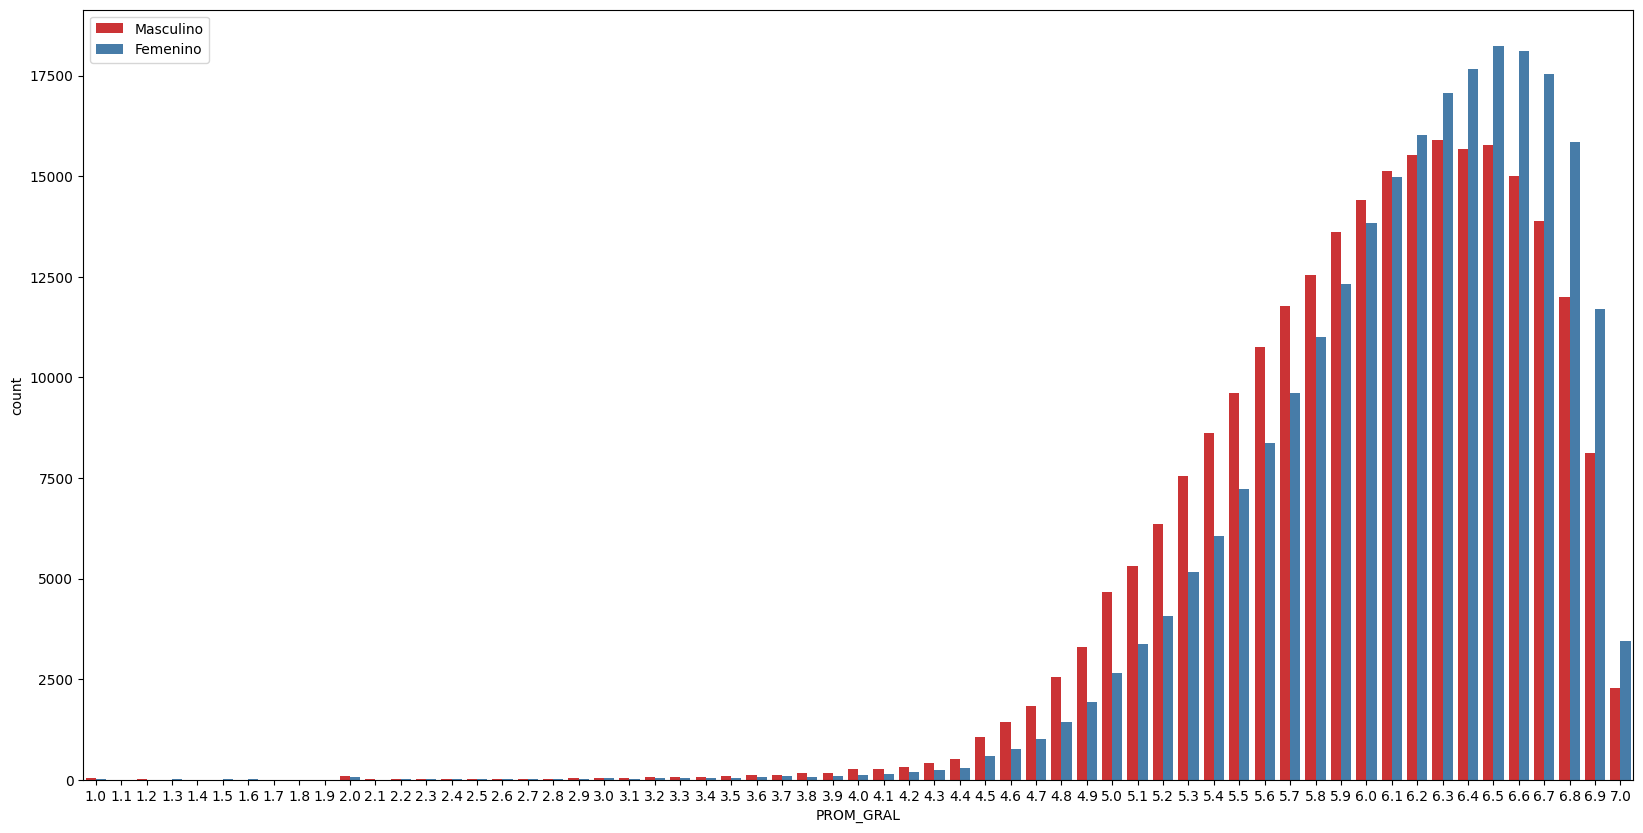

In [453]:
Test = pd.DataFrame({'PROM_GRAL': y_test, 'GEN_ALU': X_test['GEN_ALU']})

plt.figure(figsize=(20,10))
sb.countplot(x='PROM_GRAL', data=Test, hue='GEN_ALU', palette='Set1')
plt.legend(["Masculino", "Femenino"])

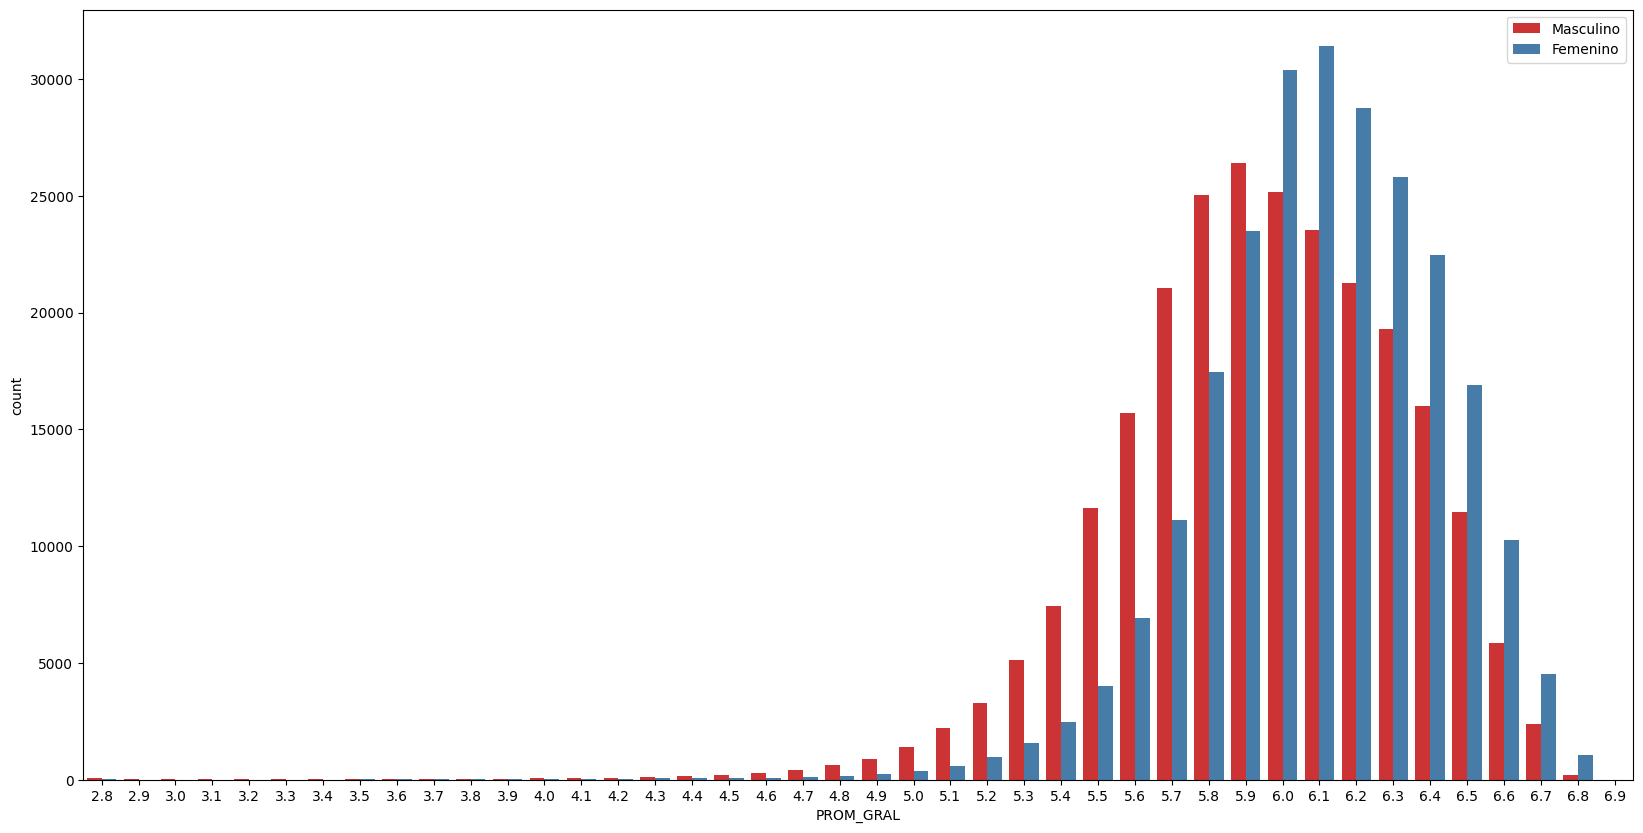

In [454]:
Pred = pd.DataFrame({'PROM_GRAL': y_pred.flatten(), 'GEN_ALU': X_test['GEN_ALU']})

plt.figure(figsize=(20,10))
sb.countplot(x='PROM_GRAL', data=Pred, hue='GEN_ALU', palette='Set1')
plt.legend(["Masculino", "Femenino"])